In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
main_dir = '/tf/notebooks/'

In [4]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2914464, 17)

In [5]:
ldadata_path = main_dir+'final-project/LDA/data/'

In [6]:
all_speeches_topics_df = pd.read_pickle(ldadata_path+'speeches_topics_ethnicity_36')
topic_names = pd.read_csv(os.path.join(ldadata_path, 'ethnicity_topics.txt'), sep="|", header=None, names=["Topic_Num", "Topic_Name"])
all_speeches_topics_df = all_speeches_topics_df.merge(topic_names, left_on='Prim_Topic', right_on='Topic_Num')\
                                               .merge(topic_names, left_on='Sec_Topic', right_on='Topic_Num')\
                                               .drop(columns=['Topic_Num_x', 'Topic_Num_y'])\
                                               .rename(columns={'Topic_Name_x': 'Prim_Topic_Name', 'Topic_Name_y': 'Sec_Topic_Name'})
all_speeches_topics_df.Speech_id = all_speeches_topics_df.Speech_id.astype('int')
all_speeches_topics_df.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id,Prim_Topic_Name,Sec_Topic_Name
0,8.0,22.0,0.35,"get,think,want,come,know,talk,us,way,see,try",32.0,0.21,1010243717,Random Verbs 2,Women's and Labor Rights
1,10.0,22.0,0.27,"get,think,want,come,know,talk,us,way,see,try",32.0,0.26,1020212973,Random Verbs 2,Women's and Labor Rights
2,11.0,22.0,0.33,"get,think,want,come,know,talk,us,way,see,try",32.0,0.15,1140043778,Random Verbs 2,Women's and Labor Rights
3,9.0,22.0,0.37,"get,think,want,come,know,talk,us,way,see,try",32.0,0.14,1040100420,Random Verbs 2,Women's and Labor Rights
4,3.0,22.0,0.69,"get,think,want,come,know,talk,us,way,see,try",32.0,0.13,1010063219,Random Verbs 2,Women's and Labor Rights


In [7]:
classdata_path = main_dir+'final-project/Classification/data/ethnicity'

In [8]:
descr_pred_df = pd.read_pickle(os.path.join(classdata_path, 'ethnicity_preds.pkl'))
descr_pred_df.shape

(62840, 20)

In [9]:
descr_pred_df.head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match,ids,pred_probs_combo,pred_combo
0,1010243717,19901025,870,166,101110870.0,D,101,H,TX,B,49.0,1.0,1.0,0.0,Mr. WASHINGTON,"WASHINGTON, CRAIG",exact,1010243717,0.432673,False
1,1120097305,20120416,1186,197,112116570.0,R,112,H,OH,AAPIA,54.0,1.0,1.0,0.0,Mr. AUSTRIA,"AUSTRIA, STEVE",fuzzy,1120097305,0.787741,True
2,1020183502,19920630,257,40,102111850.0,D,102,H,TX,H,76.0,0.0,1.0,0.0,Mr. GONZALEZ,"GONZALEZ, HENRY",exact,1020183502,0.362346,False
3,1080187463,20041001,2689,420,108115260.0,D,108,H,MD,B,53.0,1.0,1.0,0.0,Mr. WYNN,"WYNN, ALBERT",fuzzy,1080187463,0.507420,True
4,1090010764,20050309,7723,1156,109116411.0,D,109,S,HI,AAPIA,82.0,0.0,1.0,0.0,Mr. AKAKA,"AKAKA, DANIEL",exact,1090010764,0.730280,True


In [10]:
final_df = descr_pred_df.merge(all_speeches_topics_df, 
                               left_on='speech_id',
                               right_on='Speech_id')\
                        .drop(columns=['Speech_id'])
final_df.shape

(62104, 28)

In [11]:
final_df['Correct_pred'] = final_df.NonWhite == final_df.pred_combo
np.mean(final_df['Correct_pred'])

0.7675190003864485

### Average ethnicity score by topic

In [12]:
prim_topics_sorted = final_df[['pred_probs_combo', 'Correct_pred', 'Prim_Topic_Name']]\
                        .groupby('Prim_Topic_Name')\
                        .agg({'pred_probs_combo': ['count', 'mean'],
                              'Correct_pred': ['mean']})\
                        .sort_values(by=('pred_probs_combo','mean'), ascending=False)
prim_topics_sorted.columns = ['_'.join(col) for col in prim_topics_sorted.columns]
prim_topics_sorted.reset_index(inplace=True)
prim_topics_sorted

,Prim_Topic_Name,Correct_pred_mean,pred_probs_combo_count,pred_probs_combo_mean
0,Art and Culture,0.825153,326,0.689710
1,Great Nation,0.814750,1722,0.680718
2,Common Congressional Phrases 5,0.757143,630,0.619558
3,Children's and Family Programs,0.784497,1174,0.614540
4,Economy,0.825076,989,0.603903
5,Education,0.808777,1276,0.588209
6,Positive Words,0.832692,5194,0.584817
7,Healthcare Studies,0.786561,759,0.576877
8,Women's and Labor Rights,0.756140,570,0.571861
9,State and Local,0.768889,225,0.565792


In [13]:
sec_topics_sorted = final_df[['pred_probs_combo', 'Correct_pred', 'Sec_Topic_Name']]\
                        .groupby('Sec_Topic_Name')\
                        .agg({'pred_probs_combo': ['count', 'mean'],
                              'Correct_pred': ['mean']})\
                        .sort_values(by=('pred_probs_combo','mean'), ascending=False)
sec_topics_sorted.columns = ['_'.join(col) for col in sec_topics_sorted.columns]
sec_topics_sorted.reset_index(inplace=True)
sec_topics_sorted

,Sec_Topic_Name,Correct_pred_mean,pred_probs_combo_count,pred_probs_combo_mean
0,Art and Culture,0.829301,744,0.665131
1,Great Nation,0.792543,2092,0.615007
2,Children's and Family Programs,0.796097,1486,0.590322
3,Education,0.833912,1439,0.582111
4,Women's and Labor Rights,0.749400,834,0.578405
5,Common Congressional Phrases 5,0.741096,1460,0.571800
6,Positive Words,0.790667,2293,0.546174
7,Economy,0.782766,1381,0.545278
8,Healthcare Studies,0.784247,876,0.545088
9,Random Verbs,0.799151,3062,0.542341


### Topics by Congress

In [14]:
congress_df = final_df[['Congress', 'Prim_Topic_Name', 'speech_id', 'NonWhite', 'pred_probs_combo']]\
                .groupby(['Congress', 'Prim_Topic_Name'])\
                .agg({'speech_id': ['count'], 'NonWhite': ['mean', 'sum'], 'pred_probs_combo': ['mean']})
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df.reset_index(inplace=True)
congress_df.shape

(642, 6)

In [15]:
congress_df.head()

,Congress,Prim_Topic_Name,NonWhite_mean,NonWhite_sum,pred_probs_combo_mean,speech_id_count
0,97,Air Travel,0.000000,0.0,0.317146,3
1,97,Art and Culture,0.500000,5.0,0.535583,10
2,97,Bankruptcy and Liability,0.750000,3.0,0.601531,4
3,97,Children's and Family Programs,0.387097,12.0,0.430078,31
4,97,Common Congressional Phrases,0.320856,120.0,0.349603,374


In [16]:
prim_topics_sorted.Prim_Topic_Name[:5]

0                   Art and Culture
1                      Great Nation
2    Common Congressional Phrases 5
3    Children's and Family Programs
4                           Economy
Name: Prim_Topic_Name, dtype: object

In [17]:
speaker_share_congress = descr_df[['Full Name', 'Party', 'State', 'Congress', 'NonWhite']]\
                            .groupby(['Full Name', 'Party', 'State', 'Congress'])\
                            .mean()\
                            .reset_index()
speaker_share_congress = speaker_share_congress.groupby('Congress').NonWhite.mean().reset_index()
speaker_share_congress.shape

(18, 2)

In [18]:
speaker_share_congress.head()

,Congress,NonWhite
0,97,0.069725
1,98,0.081031
2,99,0.079336
3,100,0.084404
4,101,0.091241


In [19]:
speech_share_congress = descr_df[['Congress', 'NonWhite']]\
                            .groupby(['Congress'])\
                            .mean()\
                            .reset_index()
speech_share_congress.shape

(18, 2)

In [20]:
speech_share_congress.head()

,Congress,NonWhite
0,97,0.042432
1,98,0.049342
2,99,0.051600
3,100,0.050378
4,101,0.093920


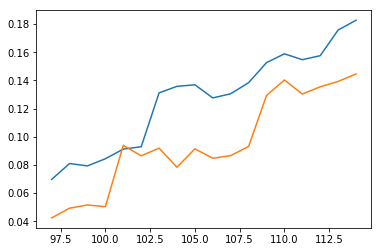

In [21]:
plt.plot(speaker_share_congress.Congress, speaker_share_congress.NonWhite)
plt.plot(speech_share_congress.Congress, speech_share_congress.NonWhite)

In [22]:
top_ethnicity_topics = list(prim_topics_sorted.Prim_Topic_Name[:5])
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

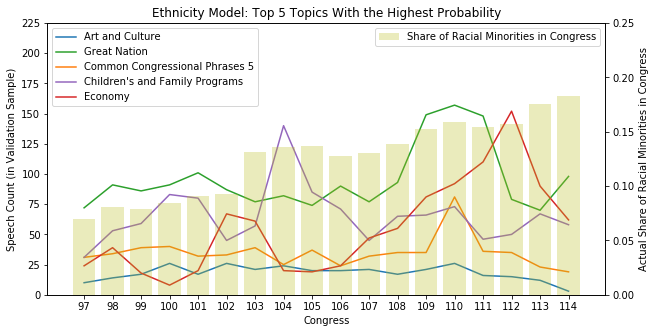

In [23]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel('Congress')
plt.ylabel('Speech Count (in Validation Sample)')
plt.title('Ethnicity Model: Top 5 Topics With the Highest Probability')

for i in range(len(top_ethnicity_topics)):
    x = congress_df[congress_df.Prim_Topic_Name==top_ethnicity_topics[i]].Congress
    y = congress_df[congress_df.Prim_Topic_Name==top_ethnicity_topics[i]].speech_id_count
    ax1.plot(x, y, color=colors[i], label=top_ethnicity_topics[i])
    ax1.set_xticks(range(97,115))
    ax1.legend()
ax1.set_ylim(0, 225)
ax2 = ax1.twinx()
ax2.bar(speaker_share_congress.Congress, speaker_share_congress.NonWhite, color='tab:olive', alpha=0.3, label='Share of Racial Minorities in Congress')
ax2.set_ylim(0, 0.25)
ax2.legend(loc='upper right')
ax2.set_ylabel('Actual Share of Racial Minorities in Congress')
plt.show()

### Topics in Classification buckets

In [24]:
topic_share = final_df[['Prim_Topic_Name', 'speech_id']].groupby('Prim_Topic_Name').count() / final_df.shape[0]
topic_share.columns = ['topic_share']
topic_share.reset_index(inplace=True)
topic_share.head()

,Prim_Topic_Name,topic_share
0,Air Travel,0.001047
1,Art and Culture,0.005249
2,Bankruptcy and Liability,0.001192
3,Children's and Family Programs,0.018904
4,Common Congressional Phrases,0.098834


In [25]:
cnt_by_pred = final_df[['NonWhite', 'pred_combo', 'speech_id']].groupby(['NonWhite', 'pred_combo']).count()
cnt_by_pred.columns = ['Speech_cnt_pred']
cnt_by_pred.reset_index(inplace=True)
cnt_by_pred['Bucket'] = ['TN', 'FP', 'FN', 'TP']
cnt_by_pred.shape

(4, 4)

In [26]:
final_df.shape

(62104, 29)

In [27]:
cnt_by_pred.head()

,NonWhite,pred_combo,Speech_cnt_pred,Bucket
0,0.0,False,25861,TN
1,0.0,True,5178,FP
2,1.0,False,9260,FN
3,1.0,True,21805,TP


In [28]:
cnt_by_pred_topic = final_df[['Prim_Topic_Name', 'NonWhite', 'pred_combo', 'speech_id']].groupby(['NonWhite', 'pred_combo', 'Prim_Topic_Name']).count()
cnt_by_pred_topic.columns = ['Speech_cnt_pred_topic']
cnt_by_pred_topic.reset_index(inplace=True)
cnt_by_pred_topic = cnt_by_pred_topic.merge(cnt_by_pred, on=['NonWhite', 'pred_combo'])
cnt_by_pred_topic['topic_pred_share'] = cnt_by_pred_topic.Speech_cnt_pred_topic / cnt_by_pred_topic.Speech_cnt_pred
cnt_by_pred_topic = cnt_by_pred_topic.merge(topic_share, on='Prim_Topic_Name')
cnt_by_pred_topic['topic_share_index'] = cnt_by_pred_topic.topic_pred_share / cnt_by_pred_topic.topic_share
cnt_by_pred_topic.shape

(144, 9)

In [29]:
cnt_by_pred_topic.head()

,NonWhite,pred_combo,Prim_Topic_Name,Speech_cnt_pred_topic,Speech_cnt_pred,Bucket,topic_pred_share,topic_share,topic_share_index
0,0.0,False,Air Travel,22,25861,TN,0.000851,0.001047,0.812800
1,0.0,True,Air Travel,8,5178,FP,0.001545,0.001047,1.476162
2,1.0,False,Air Travel,7,9260,FN,0.000756,0.001047,0.722260
3,1.0,True,Air Travel,28,21805,TP,0.001284,0.001047,1.226897
4,0.0,False,Art and Culture,58,25861,TN,0.002243,0.005249,0.427253


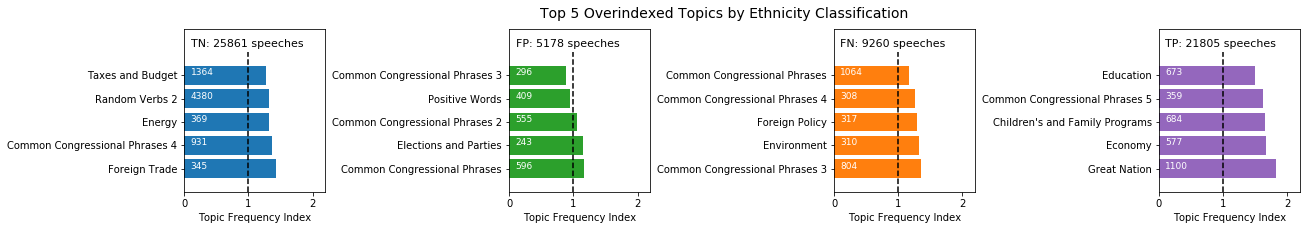

In [85]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Ethnicity Classification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

for ax, b, i in zip(axes, cnt_by_pred.Bucket, range(4)):
    temp = cnt_by_pred_topic[cnt_by_pred_topic['Bucket']==b]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[temp.Speech_cnt_pred_topic>cnt_by_pred_topic.Speech_cnt_pred_topic.median()]
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_pred_topic']]
    temp = temp.head()
    speech_cnt = cnt_by_pred[cnt_by_pred.Bucket==b].Speech_cnt_pred.values[0]
    label = b+': '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[i])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_pred_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,2.2)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

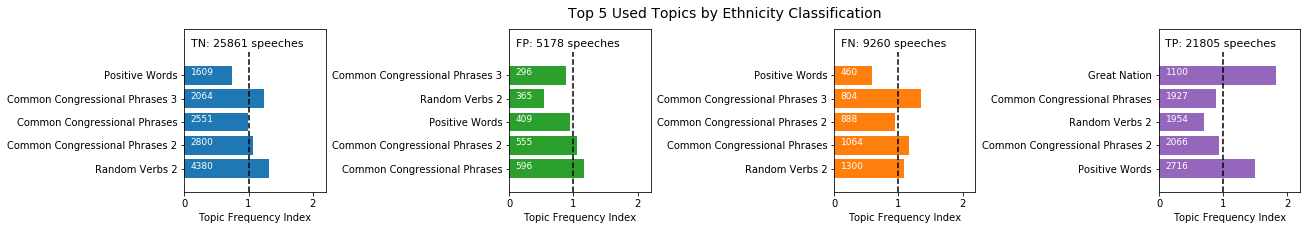

In [84]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Used Topics by Ethnicity Classification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']

for ax, b, i in zip(axes, cnt_by_pred.Bucket, range(4)):
    temp = cnt_by_pred_topic[cnt_by_pred_topic['Bucket']==b]
    temp = temp.sort_values(by='Speech_cnt_pred_topic', ascending=False)
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_pred_topic']]
    temp = temp.head()
    speech_cnt = cnt_by_pred[cnt_by_pred.Bucket==b].Speech_cnt_pred.values[0]
    label = b+': '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[i])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_pred_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,2.2)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

### Topics in Misclassified speeches

In [31]:
misclass = final_df[((final_df.NonWhite==0) & (final_df.pred_combo==1)) | ((final_df.NonWhite==1) & (final_df.pred_combo==0))]
misclass.shape

(14438, 29)

In [32]:
bins = [0, 0.4, 0.5, 0.6, 1]
misclass['binned'] = np.digitize(misclass.pred_probs_combo, bins)
misclass['binned'].value_counts()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1    5252
2    4008
3    2741
4    2437
Name: binned, dtype: int64

In [33]:
cnt_by_bin = misclass[['binned', 'speech_id']].groupby(['binned']).count().reset_index()
cnt_by_bin.columns = ['Bin', 'Speech_cnt_bin']
cnt_by_bin.head()

,Bin,Speech_cnt_bin
0,1,5252
1,2,4008
2,3,2741
3,4,2437


In [34]:
cnt_by_bin_topic = misclass[['Prim_Topic_Name', 'binned', 'NonWhite', 'speech_id']]\
                            .groupby(['binned', 'NonWhite', 'Prim_Topic_Name'])\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'Speech_cnt_bin_topic', 'binned': 'Bin'}) \
                            .merge(cnt_by_bin, on='Bin')\
                            .merge(topic_share, on='Prim_Topic_Name')
cnt_by_bin_topic['topic_bin_share'] = cnt_by_bin_topic.Speech_cnt_bin_topic / cnt_by_bin_topic.Speech_cnt_bin
cnt_by_bin_topic['topic_share_index'] = cnt_by_bin_topic.topic_bin_share / cnt_by_bin_topic.topic_share
cnt_by_bin_topic.head()

,Bin,NonWhite,Prim_Topic_Name,Speech_cnt_bin_topic,Speech_cnt_bin,topic_share,topic_bin_share,topic_share_index
0,1,1.0,Air Travel,4,5252,0.001047,0.000762,0.727682
1,2,1.0,Air Travel,3,4008,0.001047,0.000749,0.715154
2,3,0.0,Air Travel,3,2741,0.001047,0.001094,1.045727
3,4,0.0,Air Travel,5,2437,0.001047,0.002052,1.960292
4,1,1.0,Art and Culture,13,5252,0.005249,0.002475,0.471542


In [35]:
pd.crosstab(cnt_by_bin_topic.Bin, cnt_by_bin_topic.NonWhite)

NonWhite,0.0,1.0
Bin,,
1,0,36
2,0,36
3,36,0
4,36,0


In [36]:
cnt_by_bin_topic.shape

(144, 8)

In [37]:
cnt_by_bin_topic.Speech_cnt_bin_topic.sum()

14438

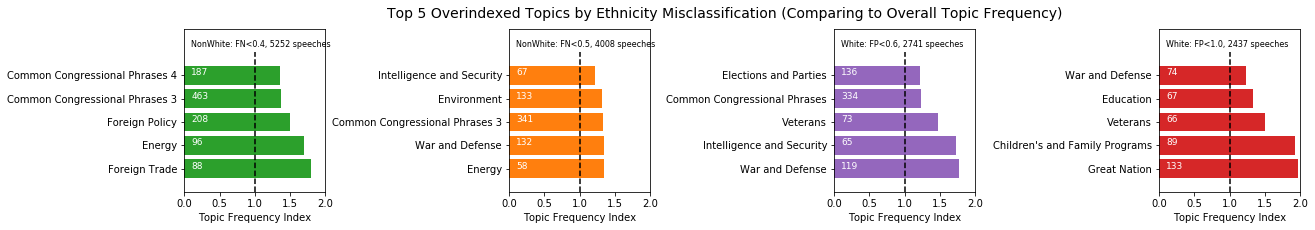

In [77]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Ethnicity Misclassification (Comparing to Overall Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['NonWhite: FN<0.4', 'NonWhite: FN<0.5', 'White: FP<0.6', 'White: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic[cnt_by_bin_topic['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='topic_share_index', ascending=False)
    temp = temp[['Prim_Topic_Name', 'topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=8)
    ax.barh(temp.Prim_Topic_Name, temp.topic_share_index, align='center', color=colors[b])
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,2)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

In [39]:
correctclass = final_df[((final_df.NonWhite==1) & (final_df.pred_combo==1)) | ((final_df.NonWhite==0) & (final_df.pred_combo==0))]
correctclass.shape

(47666, 29)

In [40]:
correctclass.shape[0]+misclass.shape[0]-final_df.shape[0]

0

In [41]:
correct_topic_cnt = correctclass[['NonWhite', 'speech_id']]\
                            .groupby('NonWhite')\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'ethnicity_topic_cnt'})
correct_topic_share = correctclass[['Prim_Topic_Name', 'NonWhite', 'speech_id']]\
                            .groupby(['Prim_Topic_Name', 'NonWhite'])\
                            .count()\
                            .reset_index()\
                            .rename(columns={'speech_id': 'ethnicity_topic_share'})\
                            .merge(correct_topic_cnt, on='NonWhite')
correct_topic_share['correct_topic_share'] = correct_topic_share.ethnicity_topic_share / correct_topic_share.ethnicity_topic_cnt
correct_topic_share.head()

,Prim_Topic_Name,NonWhite,ethnicity_topic_share,ethnicity_topic_cnt,correct_topic_share
0,Air Travel,0.0,22,25861,0.000851
1,Art and Culture,0.0,58,25861,0.002243
2,Bankruptcy and Liability,0.0,34,25861,0.001315
3,Children's and Family Programs,0.0,237,25861,0.009164
4,Common Congressional Phrases,0.0,2551,25861,0.098643


In [42]:
cnt_by_bin_topic_correct = cnt_by_bin_topic.merge(correct_topic_share, on=['Prim_Topic_Name', 'NonWhite'])
cnt_by_bin_topic_correct['correct_topic_share_index'] = cnt_by_bin_topic_correct.topic_bin_share / cnt_by_bin_topic_correct.correct_topic_share
cnt_by_bin_topic_correct.head()

,Bin,NonWhite,Prim_Topic_Name,Speech_cnt_bin_topic,Speech_cnt_bin,topic_share,topic_bin_share,topic_share_index,ethnicity_topic_share,ethnicity_topic_cnt,correct_topic_share,correct_topic_share_index
0,1,1.0,Air Travel,4,5252,0.001047,0.000762,0.727682,28,21805,0.001284,0.593107
1,2,1.0,Air Travel,3,4008,0.001047,0.000749,0.715154,28,21805,0.001284,0.582897
2,3,0.0,Air Travel,3,2741,0.001047,0.001094,1.045727,22,25861,0.000851,1.286574
3,4,0.0,Air Travel,5,2437,0.001047,0.002052,1.960292,22,25861,0.000851,2.411777
4,1,1.0,Art and Culture,13,5252,0.005249,0.002475,0.471542,211,21805,0.009677,0.255795


In [43]:
temp.Speech_cnt_bin_topic.values

array([ 23,  55, 133,   5,  25])

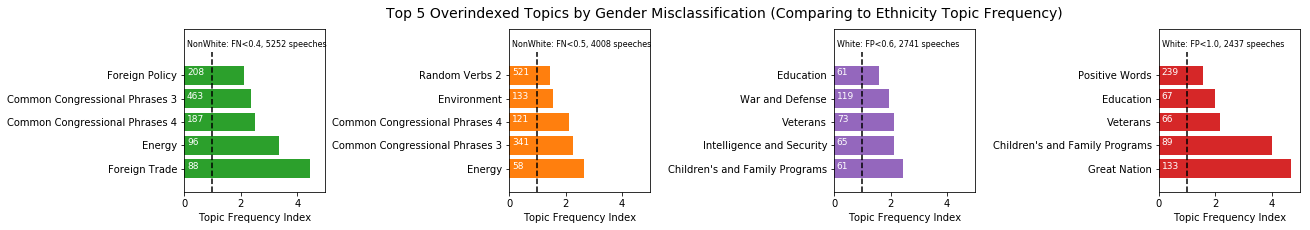

In [78]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Overindexed Topics by Gender Misclassification (Comparing to Ethnicity Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['NonWhite: FN<0.4', 'NonWhite: FN<0.5', 'White: FP<0.6', 'White: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='correct_topic_share_index', ascending=False)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=8)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,5)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

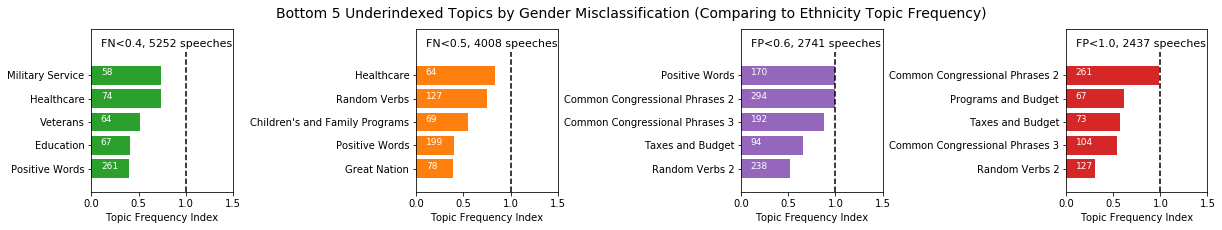

In [79]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Bottom 5 Underindexed Topics by Gender Misclassification (Comparing to Ethnicity Topic Frequency)', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['FN<0.4', 'FN<0.5', 'FP<0.6', 'FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='correct_topic_share_index', ascending=True)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=11)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9, color='white')
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,1.5)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()

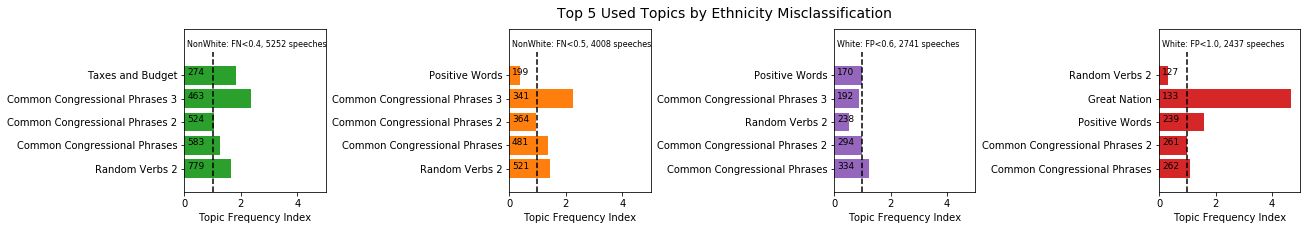

In [82]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 3))
fig.subplots_adjust(wspace=1.3)
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
fig.suptitle('Top 5 Used Topics by Ethnicity Misclassification', fontsize=14)
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
categories = ['NonWhite: FN<0.4', 'NonWhite: FN<0.5', 'White: FP<0.6', 'White: FP<1.0']

for ax, b, in zip(axes, range(1,5)):
    temp = cnt_by_bin_topic_correct[cnt_by_bin_topic_correct['Bin']==b]
    speech_cnt = temp.Speech_cnt_bin_topic.sum()
    temp = temp[temp.Speech_cnt_bin_topic>cnt_by_bin_topic_correct.Speech_cnt_bin_topic.median()]
    temp = temp.sort_values(by='Speech_cnt_bin_topic', ascending=False)
    temp = temp[['Prim_Topic_Name', 'correct_topic_share_index','Speech_cnt_bin_topic']]
    temp = temp.head()
    label = str(categories[b-1])+', '+str(speech_cnt)+' speeches'
    ax.text(0.1, 5.2, label, fontsize=8)
    for i in range(5):
        ax.text(0.1, i, temp.Speech_cnt_bin_topic.values[i], fontsize=9)
    ax.barh(temp.Prim_Topic_Name, temp.correct_topic_share_index, align='center', color=colors[b])
    ax.vlines(x=1,ymin=-1,ymax=5, linestyles='dashed')
    ax.set_xlim(0,5)
    ax.set_ylim(-1,6)
    ax.set_xlabel('Topic Frequency Index')
plt.show()